# Gist  

### 1. Problem
Below I am attempting a differentiable programming solution to what is arguably the oldest and most challenging inverse problem.   
The governing equation of the inverse problem we are interested in is none other than the (inhomogeneous) Hemlholtz Equation:  

$$\begin{equation}
\label{eq:helm}
\nabla^2\Psi(\mathbf{r}) + k^2 \psi(\mathbf{r}) = -i \sigma V(\mathbf{r})\psi(\mathbf{r})
\end{equation}
$$
where $\Psi$ is the wavefield, $V$ is the scattering potential, $k^2$ is the wavevector, and $\sigma$ is an interaction strength (or coupling constant).    
The equation above is generally applicable to all forms of radiation (lasers, x-rays...) as well as matter waves (high-energy electron beams, neutrons, etc...).  
In its most general formulation, $\Psi$ is a vector-valued complex field (i.e. to encode polarization states) or in the case of matter waves $\Psi$ is a 4-d spinor. Here, we will ignore polarization states, etc... s.t. we are dealing with scalar fields:  
$$\Psi: \mathbb{R}^3 \rightarrow \mathbb{C}, \quad V: \mathbb{R}^3 \rightarrow \mathbb{R}$$ 

The inverse problem we want to solve is given some data $D = ||\Psi_\textrm{out}||^2$, we would like to recover $V$ (and $\Psi_\textrm{in}$, most researchers only care about $V$ 🤪).  
Multiple variants of this problem arise in many fields and contexts. For instance, in imaging and sensing this inverse problem is known as object reconstruction (i.e. $V$) and in (diffraction) physics/optics it is known as the phase problem ($\arg(\Psi_\textrm{out})$ is not a measurable quantity). 

### 2. Digression #####
-----
```There is tons of approaches to solve this inverse problem (e.g. holography, tomography,) and some like Gabor and Zernike were awarded Nobel Prizes for their work on this problem ... afterall it is the **original inverse problem!**  
So, why bother finding yet another solution to this problem? well... (spoiler alert!!!🚒) none of the above solutions *actually work* in a general sense!  
And by "work in a general sense" I mean: 
1. Algo: here's the associated algorithm 
2. Data: feed it your data 
3. Solution: out comes out get a pretty good solution. 🎊

In fact, researchers, engineers, and companies have spent decades building instruments (CT scanners, microscopes, lightsources, etc...) to make the reconstruction of V easier (or in some cases, like a microscope, trivial!).   

```
-----

### 3. Paraxial Approximation and the Multi-Slice Algorithm
In what follows we use the paraxial approximation to the inhomogeneous Helmholtz equation:

$$\begin{equation}
\frac{\partial \Psi(\mathbf{r}_\perp)}{\partial z} = \frac{i \lambda}{4 \pi} \nabla_{\perp}^2 \psi(\mathbf{r}_\perp) + i \sigma V(\mathbf{r})\psi(\mathbf{r}_\perp)
\end{equation}
$$


In [1]:
using Plots, LinearAlgebra, Flux, NPZ
using Flux: Optimise
using Zygote
using FFTW
gr(size=(500,500), html_output_format=:png)

# FFTW.set_num_threads(40)

# MSA imports
include("MSA.jl")
using .MSA

# CUDAnative.device!(3)
# CuArrays.allowscalar(true)

┌ Info: CUDAdrv.jl failed to initialize, GPU functionality unavailable (set JULIA_CUDA_SILENT or JULIA_CUDA_VERBOSE to silence or expand this message)
└ @ CUDAdrv /Users/nl7/.julia/packages/CUDAdrv/b1mvw/src/CUDAdrv.jl:67


In [64]:
soft_aperture = Dict("type" => "soft", 
                     "factor" => 100.0)
hard_aperture = Dict("type" => "hard")
probe = Dict("phase_error" => "spherical", 
             "C1" => 0., 
             "C3" => 0., 
             "C5" => 0., 
             "Scherzer" => false)
simParams = MSA.SimulationState(0.05, 128, 5.6, 0.02, soft_aperture, probe)
probe_positions=[(0,0)]
sigma = 1e-1
slice_thickness = 1
num_slices = 4

# load a potential
v_file = npzread("data/potential_7559.npy")
if simParams.sampling == 128
    crop_top = map(Int, [size(v_file)[1] * (1/4), size(v_file)[2] * (3/4)])
else
    crop_top = map(Int, [size(v_file)[1] * (1/8), size(v_file)[2] * (3/8)])
end
slice = range(crop_top[1], stop=crop_top[2]-1)
v_file = v_file[slice, slice]
size(v_file)

(128, 128)

### Utils


In [3]:
mutable struct ForwardModel
    amplitude::AbstractArray
    phase::AbstractArray
    potential::AbstractArray
    simParams::MSA.SimulationState
    name::String
end

In [127]:
function forward(model::ForwardModel; buffered=true)
    psi = model.amplitude .* exp.( 1.f0 * im * model.phase)
    if buffered
        psi_out = MSA.multislice_buffered(psi, model.potential, model.simParams.λ, 
                                        slice_thickness, sigma)
    else
        psi_out = MSA.multislice(psi, model.potential, model.simParams.λ, 
                                        slice_thickness, sigma)
    end
    psi2_out = abs2.(fft(psi_out[:,:,end], [1,2]))
    return psi2_out
end

function loss(model::ForwardModel, psi2_trg)
    res = norm(forward(model) .^ 0.5 .- psi2_trg .^ 0.5, 2)
    return res
end

function sgd_update!(model::ForwardModel, grads, η = 0.01; verbose=false)
    if verbose 
        @info("Gradients:
            ∂V=$(round.(grads.potential; digits=2))
            ∂ѱ=$(round.(grads.psi; digits=2))")
        @info("before sgd update:
        V'=$(round.(model.potential; digits=2))
        ѱ'=$(round.(model.psi; digits=2))")
    end
    model.amplitude .-= η .* grads.amplitude
    model.phase .-= η .* grads.phase
    model.potential .-= η .* grads.potential
    if verbose
        @info("after sgd update:
        V'=$(round.(model.potential; digits=2))
        ѱ'=$(round.(model.psi; digits=2))")
    end
end

function comp_plot(psi_out, psi_in, V)
    l = @layout [a b c]
    p1 = heatmap(abs2.(psi_in[:,:,1]) .^ 0.25, aspect_ratio=1, framestyle = :none)
    p2 = heatmap(psi_out[:,:,1] .^ 0.1, aspect_ratio=1, framestyle = :none)
    p3 = heatmap(abs2.(V[:,:,1]), aspect_ratio=1, framestyle = :none, color = :viridis)
    heatmap(p1, p2, p3, layout=l, title=["Psi_in" "Data" "V"], size=(1200,400))
    
end

function diff_plot(psi_out_pred, psi_out_true;clims=:auto)
    heatmap(abs.(psi_out_pred[:,:,1] .- psi_out_true[:,:,1])./ psi_out_true[:,:,1] .* 100, 
        aspect_ratio=1, framestyle= :none, title="% Difference", clims= clims)
end

function build_psi(amplitude, phase)
    return amplitude .* exp.(1.f0 * im * phase)
end

build_psi (generic function with 1 method)

### Generate Solution by simulating $F$

┌ Info: Initiate Wavefunction and Scattering Potential...
└ @ Main In[122]:2


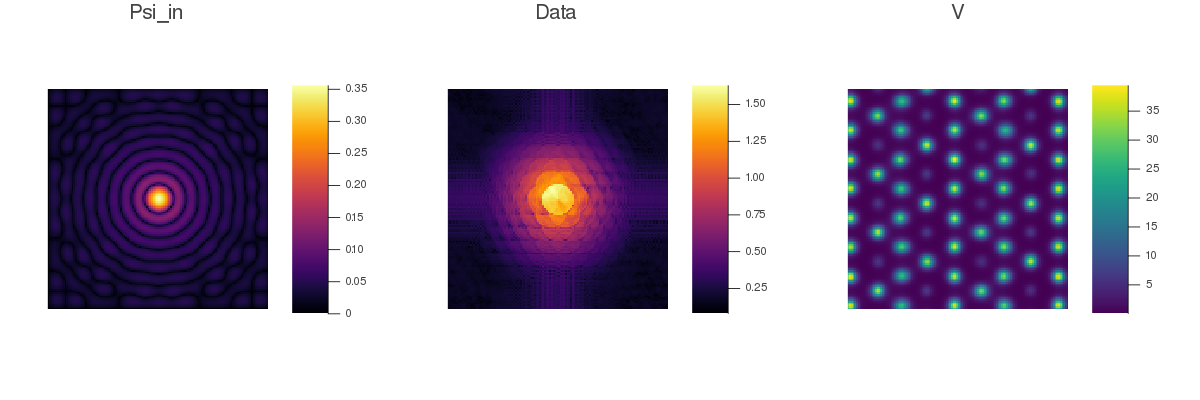

In [122]:
k_size = (simParams.sampling,simParams.sampling)
@info("Initiate Wavefunction and Scattering Potential...") 
psi, _ = MSA.build_probe(simParams)
psi_trg = psi
cpy_trg = copy(psi_trg)
V_trg = randn(ComplexF32, (k_size..., num_slices)) 
for idx in 1:size(V_trg, 3)
    V_trg[:,:,idx] = im * v_file
end
MSA.multislice!(psi_trg, V_trg, simParams.λ, slice_thickness, sigma)
psi2_trg = abs2.(psi_trg)
comp_plot(psi2_trg, cpy_trg, V_trg)

### Initiate Differentiable Forward Model, $\partial F$

┌ Info: Initiate Forward Model...
└ @ Main In[128]:1


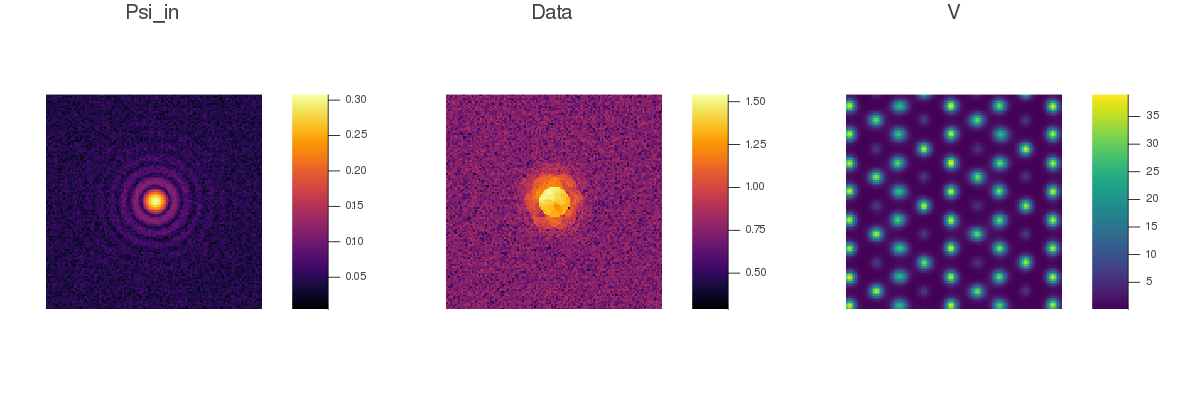

In [128]:
@info("Initiate Forward Model...")
scale = Float32(5e-1)
psi_in = randn(ComplexF64, size(psi_trg))
psi_in ./= sqrt.(sum(abs2.(psi_in)))
psi, _ = MSA.build_probe(simParams)
psi_mixing = 0.75
V_mixing = 0.99
psi_in = psi_mixing * psi + (1 - psi_mixing) * psi_in 
amplitude = abs.(psi_in) .+ 0.f0 * im * zeros(size(psi_in))
phase = angle.(psi_in) .+ 0.f0 * im * zeros(size(psi_in))
V_in = V_mixing * V_trg + (1 - V_mixing) * im * randn(Float64, size(V_trg))
model = ForwardModel(amplitude, phase, V_in, simParams, "∂F")
comp_plot(forward(model; buffered=false), build_psi(model.amplitude, model.phase), V_in)

In [129]:
# model gradients
@info("Differentiating Forward Model...")
grads = gradient(model) do m
    return loss(m, psi2_trg)
end
;

┌ Info: Differentiating Forward Model...
└ @ Main In[129]:2


### Difference between initial $\partial F$ and solution

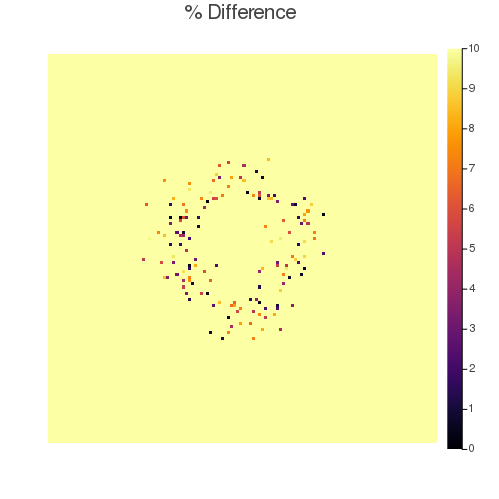

In [130]:
diff_plot(forward(model), psi2_trg, clims=(0,10))
# diff_plot(abs2.(model.psi), abs2.(psi_in))

### Optimize

In [131]:
opt = ADAM(1e-5)
@info("Running train loop")
idx = 0
loss_val = loss(model, psi2_trg)
max_iter = 5e2
num_logs = 100
verbose = false
model_hist = Array{Tuple}(undef,num_logs)
loss_hist = Array{Float32}(undef, num_logs)
iter_hist = Array{Float32}(undef, num_logs)
hist_idx = 1
@time while idx < max_iter && loss_val > 1e-4
    if mod(idx, max_iter ÷ num_logs) == 0
        Zygote.@nograd loss_val = loss(model, psi2_trg)
        println("Iteration=$(idx), Loss=$loss_val")
        model_hist[hist_idx] = (build_psi(model.amplitude, model.phase), model.potential[:,:,:])
        loss_hist[hist_idx] = loss_val
        iter_hist[hist_idx] = idx
        global hist_idx += 1
    end
    grads= Zygote.gradient(model) do m
        return loss(m, psi2_trg)
    end
    grads = grads[1][]
    sgd_update!(model, grads, 1e-4; verbose=false)
#     Optimise.update!(opt, model.psi, grads.psi)
#     Optimise.update!(opt, model.potential, grads.potential)
    global idx += 1
end

┌ Info: Running train loop
└ @ Main In[131]:2


Iteration=0, Loss=43.784554469904876
Iteration=5, Loss=35.57110996290318
Iteration=10, Loss=27.352607029697534
Iteration=15, Loss=19.128782786592915
Iteration=20, Loss=10.8994404925915
Iteration=25, Loss=2.664643487266408
Iteration=30, Loss=1.049130221195478
Iteration=35, Loss=0.5976203312561529
Iteration=40, Loss=1.0561608822583282
Iteration=45, Loss=0.5986419768755693
Iteration=50, Loss=1.0598343103471002
Iteration=55, Loss=0.5978108793543565
Iteration=60, Loss=1.0629679742085045
Iteration=65, Loss=0.5962104188845544
Iteration=70, Loss=1.0659416716593926
Iteration=75, Loss=0.5941482082190972
Iteration=80, Loss=1.0688571962066857
Iteration=85, Loss=0.5917803003310524
Iteration=90, Loss=1.0717565675461758
Iteration=95, Loss=0.5892034114630197
Iteration=100, Loss=1.0746628244499778
Iteration=105, Loss=0.5864805030315883
Iteration=110, Loss=1.077588069851094
Iteration=115, Loss=0.5836522261966649
Iteration=120, Loss=1.0805378750168864
Iteration=125, Loss=0.5807451886872269
Iteration=130,

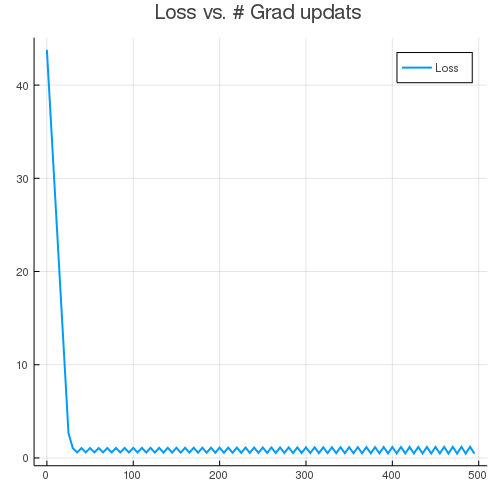

In [132]:
plot(iter_hist, loss_hist, lw=2, title="Loss vs. # Grad updats", label="Loss")

### Difference between optimized $\partial F$ and solution

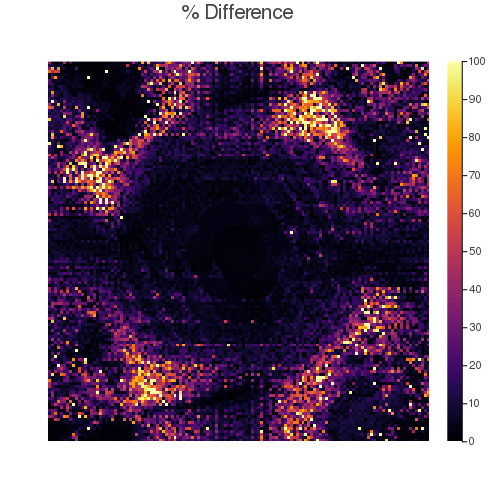

In [133]:
diff_plot(forward(model), psi2_trg; clims=(0,100))

### Optimization History of $\bar\Psi_{\textrm{in}}$

In [134]:
anim = @animate for ((psi,potential), iter) in zip(model_hist, 0:num_logs:idx)
    psi = abs2.(psi[:,:,1]) .^ 0.5
    pot = sum(abs2.(potential), dims=3)[:,:,1]
    l = @layout [a b]
    p1 = heatmap(psi, aspect_ratio=1, framestyle = :none, color= :vibrant_grad)
    p2 = heatmap(pot .^ 0.5, aspect_ratio=1, framestyle = :none, color= :vibrant_grad)
    heatmap(p1, p2, layout=l, title=["Psi_in\n Iterations=$iter" "V"], size=(800,400))
end

Animation("/var/folders/8f/t9hfgr0j79n6bm8jw7k_y8f91v961s/T/jl_9gNm4Q", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png"])

┌ Info: Saved animation to 
│   fn = /Users/nl7/work/diffpsi/diffProg_psi_in.gif
└ @ Plots /Users/nl7/.julia/packages/Plots/XpHkc/src/animation.jl:98


Plots.AnimatedGif("/Users/nl7/work/diffpsi/diffProg_psi_in.gif")
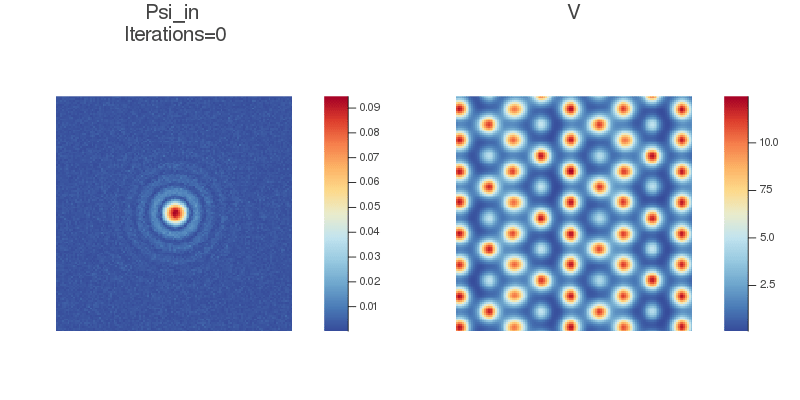

In [135]:
gif(anim, "diffProg_psi_in.gif", fps=5)

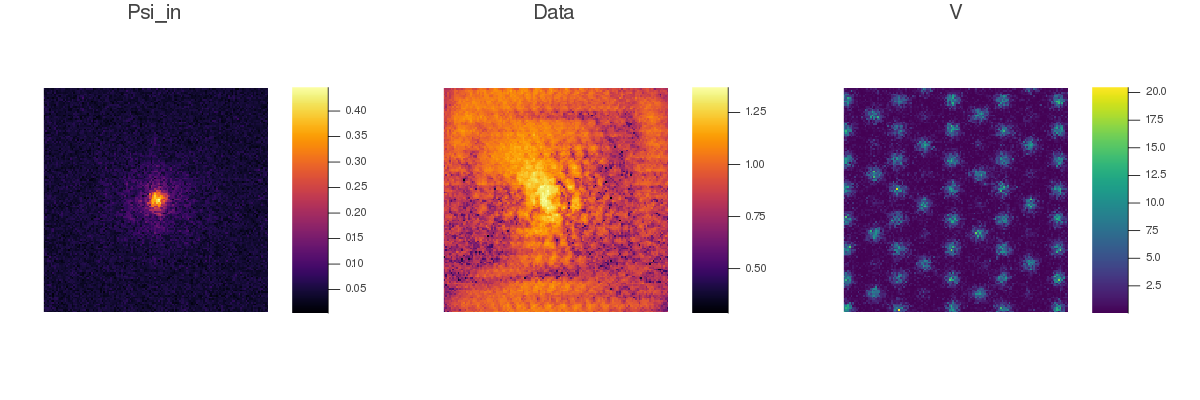

In [84]:
comp_plot(forward(model), build_psi(model.amplitude, model.phase), model.potential)

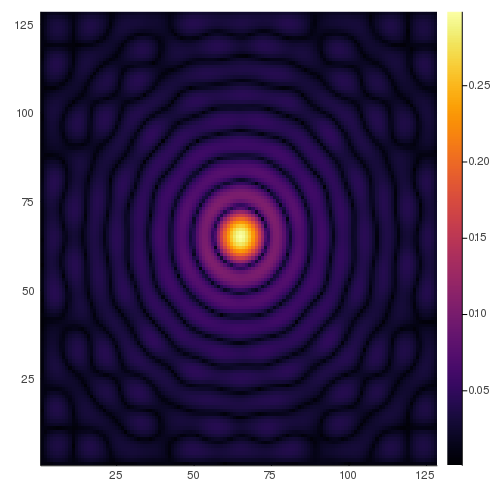

In [24]:
heatmap(abs2.(model.amplitude)[:,:,1] .^ 0.25)

In [15]:
prod_pred = model.psi .* MSA.build_transmPropagator(model.potential[:,:,1],sigma)
heatmap(abs2.(prod_pred)[:,:,1], aspect_ratio=1, framestyle= :none)

ErrorException: type ForwardModel has no field psi

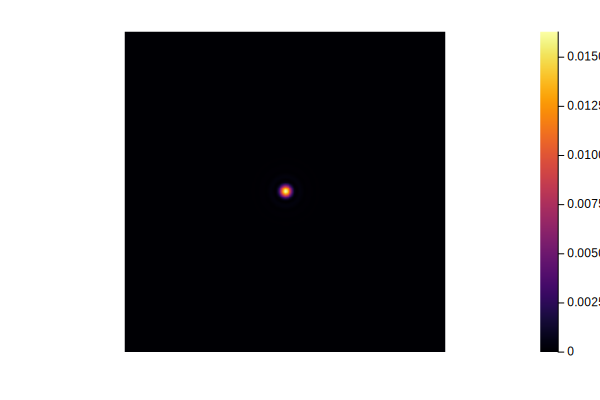

In [26]:
prod_true = psi .* MSA.build_transmPropagator(V_trg[:,:,1],sigma)
heatmap(abs2.(prod_true)[:,:,1], aspect_ratio=1, framestyle= :none)